## Analysis of blood glucose data to assess the reproducibility of the post-prandial blood glucose response (PPGR)
### Process the raw blood glucose data to generate 'glucose events' (initail nadir / peak / secondary nadir)

1. Preprocess the raw data
2. Seasonality : 4 hour window periods
3. Standard deviation for 4 hour periods
4. Timestamps matched for carbohydrate intake (i.e. all 35g CHO within 1 hour of eachother grouped together)
5. Rate of glucose appearance and disappearance<br>
    *a. Glucose excursion (nadir to peak / peak to nadir) - +ve and -ve trends*<br>
    *b. iAUC (nadir to peak / peak to nadir) - +ve and -ve trends*
6. Total change in BG (nadir to peak / peak to nadir) - +ve and -ve 
7. Incude the Carbs consumed in the 4 hour period
8. Collate the results of the above points into a data set with columns names:
    * Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)  
    * Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
    * Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
    * Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
    * Time period Number (1 / 2 / 3 / 4 / 5)
    * iAUC (+ve)
    * iAUC (-ve)
    * ROA / Glucose Excursion (+ve)
    * ROD / Glucose Excursion (-ve)
    * Total change in BG (+ve)
    * Total change in BG (-ve)
    * Peak value
    * Carbs
9. Generate a DataFrame of the glucose event parameters

### 'Cluster' or group the glucose events accoridng to clinically relevant parameters
1. 'Cluster' the glucose events based on the following set of rules
    * Rate of glucose appearance (ROA) / 
    * positive_iAUC (initial_nadir to peak)
    * Rate of gluocse dissapearance (ROD)
    * negative_iAUC (peak to second_nadir)
    * Elapsed time between initial_nadir and secondary_nadir points (time_lapse)
    * Carb intake in time frame

### Review the appropriatness of the 'clustering' or grouping
1. Goodness of fit assessment :
    * Want the algorithm to be adaptive.
    * Have the left overs recycled through the 'rules' missing the glucose excursion but maintaining the iAUC and total change in BG.
    * Then further iterations miss out the iAUC and review total change in BG etc

### Import/load necessary libraries 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
from datetime import timedelta
from statistics import mode
from scipy.signal import find_peaks

%matplotlib inline

### Load and preprocess necessary data sets

In [7]:
def read_data(filename):
    unfiltered = pd.read_csv(os.path.join("CSV Files", filename))
    unfiltered['glucose_level_ts'] = pd.to_datetime(unfiltered['glucose_level_ts'], dayfirst=True)
    unfiltered.drop('glucose_level_mmol/L', axis=1, inplace=True)
    return unfiltered

In [8]:
def slice_data(data, time_step, n_samples):
    timestamp = np.array(data['glucose_level_ts'], dtype=float)
    glucose = np.array(data['glucose_level_mg/dL'], dtype=float)
    n_samples_per_segment = int(time_step / timedelta(minutes=1)) * n_samples
    glucose_seg_ts = [timestamp[i:i + n_samples_per_segment] for i in range(0, len(data), n_samples_per_segment)]
    glucose_sliced = [glucose[i:i + n_samples_per_segment] for i in range(0, len(data), n_samples_per_segment)]
    return glucose_sliced, glucose_seg_ts

In [9]:
unfiltered = read_data('544_data.csv')

In [10]:
# Select glucose level and timestamp features
features = ['glucose_level_ts', 'glucose_level_mg/dL']
data = unfiltered[features].copy()

# Map day of week names to day of week numbers
data['day_of_week'] = data['glucose_level_ts'].dt.dayofweek
data['day_of_week_name'] = data['glucose_level_ts'].dt.day_name()

# Set time step in minutes
time_step = data['glucose_level_ts'].diff().mode()[0] / timedelta(minutes=1)

# Calculate rate of change
data['bg_rate_of_change'] = data['glucose_level_mg/dL'].diff() / time_step

In [11]:
prominence = 18 

elements_per_6hours = 72  # 72 BG samples in 6 hours sample

### Isolate the peak and nadir (low) points in the set windows

In [12]:
# sliced data set into 4 hour segments

timestamp = data['glucose_level_ts'].to_numpy('datetime64')
glucose = data['glucose_level_mg/dL'].to_numpy('float32')

elements_per_6hours = 72  # 72 BG samples in 6 hours sample
glucose_seg_ts = [timestamp[i:i+elements_per_6hours] for i in range(0, len(data), elements_per_6hours)]
glucose_sliced = [glucose[i:i+elements_per_6hours] for i in range(0, len(data), elements_per_6hours)]

glucose_segment = glucose_sliced[1] #selecting the 3rd segment, for example
glucose_segment_ts = glucose_seg_ts[1] 

print("Length of glucose segment:", len(glucose_segment))

# # find peaks and troughs
# peaks, _ = find_peaks(glucose_segment)
# troughs, _ = find_peaks(-glucose_segment)

# # Print peaks and troughs
# print("Peaks: ", peaks)
# print("Troughs: ", troughs)

# # Check the length of the peaks and troughs lists
# print("Length of peaks:", len(peaks))
# print("Length of troughs:", len(troughs))

Length of glucose segment: 72


In [13]:
def split_df(df, chunk_size): 
    num_chunks = len(df) // chunk_size + 1
    chunks = [df[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)]
    return chunks

In [14]:
glucose_ts_sliced = split_df(data['glucose_level_ts'], chunk_size=elements_per_6hours)
glucose_value_sliced = split_df(data['glucose_level_mg/dL'], chunk_size=elements_per_6hours)
glucose_ts_sliced_ = glucose_ts_sliced[1]
glucose_value_sliced_ = glucose_value_sliced[1]

In [15]:
(peaks, _), (troughs, _) = map(find_peaks, [glucose_value_sliced_, -glucose_value_sliced_])

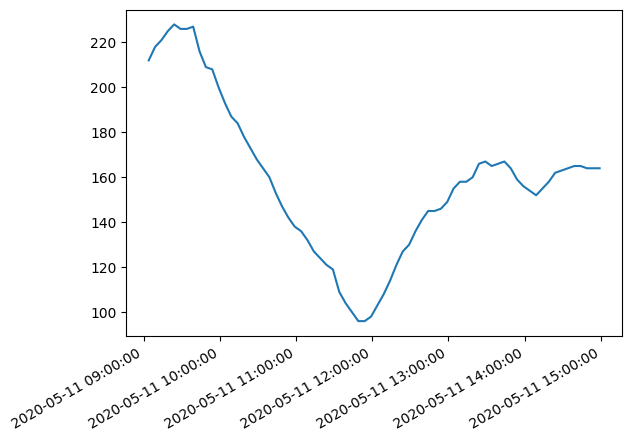

In [16]:
import matplotlib.dates as mdates

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(glucose_ts_sliced_, glucose_value_sliced_)
fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(fmt)
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')

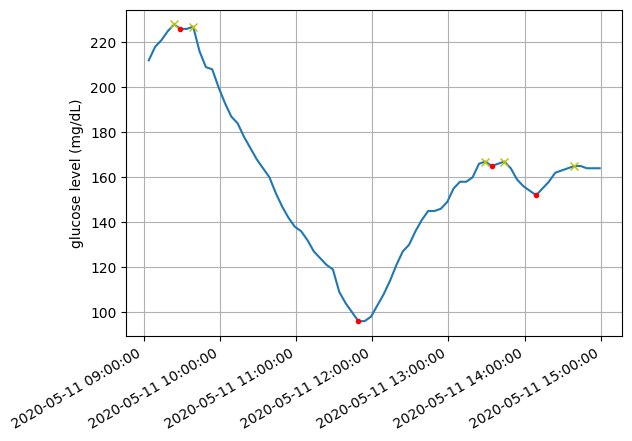

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.grid()

ax1.plot(glucose_ts_sliced_, glucose_value_sliced_)
ax1.plot(glucose_ts_sliced_.iloc[peaks], glucose_value_sliced_.iloc[peaks], "yx")
ax1.plot(glucose_ts_sliced_.iloc[troughs], glucose_value_sliced_.iloc[troughs], "r.")
ax1.set_ylabel('glucose level (mg/dL)')

fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax1.xaxis.set_major_formatter(fmt)
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')

### Isolate the Glucose Events (initial low, peak and secondary low)

In [18]:
max_nadir_to_peak_time, max_peak_to_2nd_nadir_time, max_peak_to_peak_time = map(
    lambda x: datetime.timedelta(hours=x), [2, 4, 6])

In [19]:
# Set time threshold values for glycemic events
max_nadir_to_peak_time = timedelta(hours=2)
max_peak_to_2nd_nadir_time = timedelta(hours=4)
max_peak_to_peak_time = timedelta(hours=6)

events = []
for i in range(len(glucose_sliced)):
    glucose_segment = glucose_sliced[i]
    glucose_segment_ts = glucose_seg_ts[i]

    # find peaks and troughs
    peaks, _ = find_peaks(glucose_segment)
    troughs, _ = find_peaks(-glucose_segment)

    VERBOSE = False #False # set to True for parameter tuning/debugging

    # Ignore peaks that appear before any nadirs, or that have no (secondary) nadir afterwards
    ignored_peaks = (peaks < troughs[0]) | (peaks > troughs[-1])  

    counter =0
    # Loop through all peaks
    for j, idx in enumerate(peaks):
        
        if ignored_peaks[j]: 
            if VERBOSE: print(f"peak #{j} ({idx}) ignored")        
            continue    
        
        # Find the last nadir event that occurred before the peak event
        last_nadir_idx = troughs[ np.flatnonzero(troughs < idx)[-1] ]  
        print(last_nadir_idx)

        # check that event occurred within the time threshold
        if (idx - last_nadir_idx)*time_step < max_nadir_to_peak_time.total_seconds()/60:                 
            print(glucose_segment_ts[last_nadir_idx])                               
            initial_nadir = (glucose_segment[last_nadir_idx], glucose_segment_ts[last_nadir_idx])     
            
        else:
            if VERBOSE: print(f"No nadir found for peak #{i} ({idx})")  
            continue # nadir too far behind peak
                      
        # Find the first nadir event that occurred after the peak event 
        next_nadir_idx = troughs[ np.flatnonzero(troughs > idx)[0] ]  
        
        # check that event occurred within the time threshold
        if (next_nadir_idx - idx)*time_step < max_peak_to_2nd_nadir_time.total_seconds()/60:            
        
            secondary_nadir = (glucose_segment[next_nadir_idx], glucose_segment_ts[next_nadir_idx])   
            
        else:
            if VERBOSE: print(f"No secondary nadir found for peak #{j} ({idx})")
            continue # nadir too far ahead of peak
        
        
        # What to do if there is more than one peak within j and k?
        between_jk = np.flatnonzero( (peaks > j) & (peaks < next_nadir_idx) ) 
        
        #print(len(between_jk))
        if len(between_jk) > 1:
        # Currently: ignore all but the highest of them
            counter = counter + 1 
        
            peaks_jk = peaks[between_jk]                         
            l = peaks_jk[ np.argmax(glucose_segment[ peaks_jk ]) ] 

            # Make sure peak l is not accounted twice
            ignored_peaks[ between_jk ] = True                           

            event_peak = (glucose_segment[l], glucose_segment_ts[l]) 
            
            if VERBOSE: print(f"Choosing ({l}), out of",len(between_jk),"peaks between",j,"and",k)  
        else:
            event_peak = (glucose_segment[idx], glucose_segment_ts[idx])

    # Add the event to the events list
    events.append({
        'initial_nadir_idx': j,
        'initial_nadir_glucose': initial_nadir[0],
        'initial_nadir_time': initial_nadir[1],
        'peak_glucose': event_peak[0],
        'peak_time': event_peak[1],
        'secondary_nadir_glucose': secondary_nadir[0],
        'secondary_nadir_time': secondary_nadir[1]
    })

#print("number of inbetweens " + str(counter))
# Create a pandas dataframe from the events list
df_events = pd.DataFrame.from_dict(events)
df_events['initial_nadir_time'] = pd.to_datetime(df_events['initial_nadir_time'], dayfirst=True)
df_events['peak_time'] = pd.to_datetime(df_events['peak_time'], dayfirst=True)
df_events['secondary_nadir_time'] = pd.to_datetime(df_events['secondary_nadir_time'], dayfirst=True)


1
2020-05-11T00:07:00.000000000
6
2020-05-11T00:32:00.000000000
12
2020-05-11T01:02:00.000000000
21
2020-05-11T01:47:00.000000000
42
2020-05-11T03:32:00.000000000
45
2020-05-11T03:47:00.000000000
65
2020-05-11T05:27:00.000000000
5
2020-05-11T09:29:00.000000000
33
2020-05-11T11:49:00.000000000
54
2020-05-11T13:34:00.000000000
3
2020-05-11T15:19:00.000000000
26
2020-05-11T17:14:00.000000000
30
2020-05-11T17:34:00.000000000
54
2020-05-11T19:34:00.000000000
57
2020-05-11T19:49:00.000000000
61
2020-05-11T20:09:00.000000000
2
2020-05-11T21:14:00.000000000
4
2020-05-11T21:24:00.000000000
7
2020-05-11T21:39:00.000000000
25
2020-05-11T23:09:00.000000000
30
2020-05-11T23:34:00.000000000
42
2020-05-12T00:34:00.000000000
49
2020-05-12T01:09:00.000000000
61
2020-05-12T02:09:00.000000000
64
2020-05-12T02:24:00.000000000
4
2020-05-12T03:24:00.000000000
12
2020-05-12T04:04:00.000000000
22
2020-05-12T04:54:00.000000000
25
2020-05-12T05:09:00.000000000
29
2020-05-12T05:29:00.000000000
33
2020-05-12T05:4

In [20]:
# Adjust the time columns to an appropriate date-time format

df_events['initial_nadir_time'] = pd.to_datetime(df_events['initial_nadir_time'])
df_events['peak_time'] = pd.to_datetime(df_events['peak_time'])
df_events['secondary_nadir_time'] = pd.to_datetime(df_events['secondary_nadir_time'])

In [21]:
df_events

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time
0,6,153.0,2020-05-11 05:27:00,206.0,2020-05-11 08:49:00,204.0,2020-05-11 08:54:00
1,4,165.0,2020-05-11 13:34:00,228.0,2020-05-11 09:24:00,152.0,2020-05-11 14:09:00
2,7,205.0,2020-05-11 20:09:00,229.0,2020-05-11 20:29:00,225.0,2020-05-11 20:34:00
3,10,149.0,2020-05-12 02:24:00,259.0,2020-05-11 22:19:00,166.0,2020-05-12 02:39:00
4,10,166.0,2020-05-12 07:49:00,191.0,2020-05-12 08:19:00,182.0,2020-05-12 08:34:00
...,...,...,...,...,...,...,...
181,5,75.0,2020-07-03 19:28:00,143.0,2020-07-03 21:23:00,122.0,2020-07-03 21:48:00
182,4,226.0,2020-07-04 02:38:00,306.0,2020-07-04 00:58:00,226.0,2020-07-04 02:58:00
183,4,100.0,2020-07-04 11:27:00,174.0,2020-07-04 06:23:00,130.0,2020-07-04 12:22:00
184,6,268.0,2020-07-04 18:37:00,316.0,2020-07-04 19:17:00,298.0,2020-07-04 19:32:00


### Calculate the total change in BG (nadir to peak / peak to nadir) 
* +ve change -> Glucose_rise 
* -ve change -> glucose_drop

In [22]:
df_events['glucose_rise'] = df_events['peak_glucose'] - df_events['initial_nadir_glucose']
df_events['glucose_drop'] = df_events['secondary_nadir_glucose'] - df_events['peak_glucose']

In [23]:
df_events

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop
0,6,153.0,2020-05-11 05:27:00,206.0,2020-05-11 08:49:00,204.0,2020-05-11 08:54:00,53.0,-2.0
1,4,165.0,2020-05-11 13:34:00,228.0,2020-05-11 09:24:00,152.0,2020-05-11 14:09:00,63.0,-76.0
2,7,205.0,2020-05-11 20:09:00,229.0,2020-05-11 20:29:00,225.0,2020-05-11 20:34:00,24.0,-4.0
3,10,149.0,2020-05-12 02:24:00,259.0,2020-05-11 22:19:00,166.0,2020-05-12 02:39:00,110.0,-93.0
4,10,166.0,2020-05-12 07:49:00,191.0,2020-05-12 08:19:00,182.0,2020-05-12 08:34:00,25.0,-9.0
...,...,...,...,...,...,...,...,...,...
181,5,75.0,2020-07-03 19:28:00,143.0,2020-07-03 21:23:00,122.0,2020-07-03 21:48:00,68.0,-21.0
182,4,226.0,2020-07-04 02:38:00,306.0,2020-07-04 00:58:00,226.0,2020-07-04 02:58:00,80.0,-80.0
183,4,100.0,2020-07-04 11:27:00,174.0,2020-07-04 06:23:00,130.0,2020-07-04 12:22:00,74.0,-44.0
184,6,268.0,2020-07-04 18:37:00,316.0,2020-07-04 19:17:00,298.0,2020-07-04 19:32:00,48.0,-18.0


Isolate the gluocse event based on either bolus injection or meal consumed

In [24]:
unfiltered.head()

,glucose_level_ts,glucose_level_mg/dL,carbs_g,meal_ts,meal_type,bolus_dose,bolus_start_ts,bolus_end_ts,bolus_type
0,2020-05-11 00:02:00,129,135.0,11/05/2020 11:25,Lunch,7.1,11/05/2020 08:24,11/05/2020 08:24,normal
1,2020-05-11 00:07:00,128,100.0,11/05/2020 17:16,Dinner,16.8,11/05/2020 11:24,11/05/2020 11:24,normal
2,2020-05-11 00:12:00,129,42.0,11/05/2020 21:26,Snack,14.2,11/05/2020 17:19,11/05/2020 17:19,normal
3,2020-05-11 00:17:00,131,37.0,12/05/2020 08:02,Breakfast,7.5,11/05/2020 21:23,11/05/2020 21:23,normal
4,2020-05-11 00:22:00,133,78.0,12/05/2020 12:07,Lunch,6.9,12/05/2020 08:00,12/05/2020 08:00,normal


In [25]:
# Set the time window to 5 minutes (300 seconds)
time_window = 5

# Set the number of samples (for slicing) as desired
n_samples = 48

# Define the correction dose window (e.g., 30 minutes)
correction_window = (10, 30)

# List to store glucose segments for each bolus event
glucose_sliced_segments = []

# List to store timestamps for each glucose segment
glucose_seg_ts_segments = []

In [26]:
def find_closest_timestamp(bolus_start_ts, glucose_level_ts):
    # Convert bolus_start_ts to datetime, handling errors with 'coerce'
    bolus_start_ts = pd.to_datetime(bolus_start_ts, dayfirst=True, errors='coerce')

    # Handle NaN and float values
    if pd.isnull(bolus_start_ts) or isinstance(bolus_start_ts, float):
        return None

    # Convert bolus_start_ts to a pandas Timestamp object
    bolus_start_ts = pd.Timestamp(bolus_start_ts)

    # Convert bolus_start_ts and glucose_level_ts to NumPy datetime arrays
    bolus_start_ts = np.array(bolus_start_ts, dtype='datetime64')
    glucose_level_ts = np.array(glucose_level_ts, dtype='datetime64')

    closest_index = np.argmin(np.abs(glucose_level_ts - bolus_start_ts))

    return glucose_level_ts[closest_index]

In [27]:
def slice_data(unfiltered, time_window, n_samples, bolus_start_ts):
    glucose_timestamps = np.array(unfiltered['glucose_level_ts'], dtype='datetime64')
    glucose_values = np.array(unfiltered['glucose_level_mg/dL'], dtype=float)
    bolus_timestamps = np.array(unfiltered['bolus_start_ts'], dtype='datetime64')
    meal_timestamps = np.array(unfiltered['meal_ts'], dtype='datetime64')

    closest_bolus_glucose_ts = find_closest_timestamp(bolus_start_ts, glucose_timestamps)
    closest_meal_glucose_ts = find_closest_timestamp(unfiltered['meal_ts'].iloc[0], glucose_timestamps)

    # Determine which timestamp to use based on availability
    if pd.notnull(closest_bolus_glucose_ts):
        selected_glucose_ts = closest_bolus_glucose_ts
    elif pd.notnull(closest_meal_glucose_ts):
        selected_glucose_ts = closest_meal_glucose_ts
    else:
        return None, None

    # Check if selected_glucose_ts is NaT and return None if it is
    if pd.isnull(selected_glucose_ts) or pd.isnull(bolus_start_ts):
        return None, None

    time_difference = abs(bolus_start_ts - selected_glucose_ts)

    # Check if the selected glucose timestamp is within the time window
    if time_difference <= pd.Timedelta(minutes=time_window):
        start_index = np.where(glucose_timestamps == selected_glucose_ts)[0][0]
        end_index = start_index + n_samples
        glucose_sliced = glucose_values[start_index:end_index]
        glucose_seg_ts = glucose_timestamps[start_index:end_index]
        return glucose_sliced, glucose_seg_ts
    else:
        return None, None

In [28]:
# Define function to check for correction doses
def is_correction_dose(bolus_start_ts, meal_ts, correction_window):
    if pd.notnull(meal_ts):
        # Convert both timestamps to the same format before calculating time difference
        main_dose = np.datetime64(bolus_start_ts)
        meal_ts = np.datetime64(meal_ts)
        time_difference = (main_dose - meal_ts).astype('timedelta64[m]').astype(int)
        return correction_window[0] <= time_difference <= correction_window[1]
    return False  # Return False if meal_ts is missing (NaN)

In [29]:
# Iterate through each bolus event
for bolus_start_ts in unfiltered['bolus_start_ts']:
    # Slice the data based on the closest glucose timestamp to the bolus timestamp
    glucose_sliced, glucose_seg_ts = slice_data(unfiltered, time_window, n_samples, bolus_start_ts)
    
    # Check if any segments were found and if it's not a correction dose
    if glucose_sliced is not None and len(glucose_sliced) > 0:
        # Filter out non-numeric values from the glucose_sliced array
        glucose_sliced_numeric = glucose_sliced[~np.isnan(glucose_sliced)]
        
        # Convert glucose_sliced_numeric to a NumPy datetime array
        glucose_sliced_datetime = np.array(glucose_sliced_numeric, dtype='datetime64')
        
        # Find the nearest meal timestamp within the correction window
        meal_ts = unfiltered[(unfiltered['glucose_level_ts'] <= bolus_start_ts) & (bolus_start_ts - unfiltered['glucose_level_ts'] <= pd.Timedelta(minutes=correction_window[1]))]['meal_ts'].max()
        
        # Check if it's a correction dose based on the filtered glucose_sliced_datetime
        if is_correction_dose(glucose_sliced_datetime[0], meal_ts, correction_window):
            glucose_sliced_segments.append(glucose_sliced)
            glucose_seg_ts_segments.append(glucose_seg_ts)

ValueError: Cannot create a NumPy datetime other than NaT with generic units

In [ ]:
# Check if any segments were found
if len(glucose_sliced_segments) > 0:
    # Plotting code
    fig, ax = plt.subplots(len(glucose_sliced_segments), 1, figsize=(12, 6 * len(glucose_sliced_segments)))
    fig.tight_layout()

    for i, segment in enumerate(glucose_sliced_segments):
        ax[i].grid()
        ax[i].plot(glucose_seg_ts_segments[i], segment)
        ax[i].plot(glucose_seg_ts_segments[i][peaks[i]], segment[peaks[i]], "yx")
        ax[i].plot(glucose_seg_ts_segments[i][troughs[i]], segment[troughs[i]], "r.")
        ax[i].set_ylabel('glucose level (mg/dL)')

        fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
        ax[i].xaxis.set_major_formatter(fmt)
        ax[i].tick_params(axis='x', rotation=30)

    plt.xlabel('Timestamp')
    plt.show()
else:
    print("No segments found.")

### Calculate glucose appearrance and disappearance rates
* Glucose excursion (mmol/L.min-1) / ROA & ROD
* positive and negative iAUCs

In [ ]:
# Create empty lists to store the iAUC values
iauc_positive = []
iauc_negative = []

# Iterate through each row in the DataFrame
for index, row in df_events.iterrows():
    # Calculate iAUC between 'initial_nadir_glucose' and 'peak_glucose'
    iauc_positive.append(np.trapz([row['initial_nadir_glucose'], row['peak_glucose']], dx=5))

    # Calculate iAUC between 'peak_glucose' and 'secondary_nadir_glucose'
    iauc_negative.append(np.trapz([row['peak_glucose'], row['secondary_nadir_glucose']], dx=5))

# Convert the lists to Series
iauc_positive = pd.Series(iauc_positive)
iauc_negative = pd.Series(iauc_negative)

# Add the iAUCs to the df_events dataframe
df_events['positive_iAUC'] = iauc_positive
df_events['negative_iAUC'] = iauc_negative

### Calculate the gradient of the glucose rise and drop

In [ ]:
# calculate the positive and negative gradient of the blod glucose change
# Convert TimedeltaArray to numeric type
time_diff_pos = df_events['peak_time'] - df_events['initial_nadir_time']
time_diff_neg = df_events['peak_time'] - df_events['secondary_nadir_time']
time_diff_pos = time_diff_pos.dt.total_seconds() / 60  # Convert to minutes
time_diff_neg = time_diff_neg.dt.total_seconds() / 60  # Convert to minutes

positive_gradient = (df_events['peak_glucose'] - df_events['initial_nadir_glucose']) / time_diff_pos
negative_gradient = (df_events['peak_glucose'] - df_events['secondary_nadir_glucose']) / time_diff_neg

# Add the iAUCs to the df_events dataframe
df_events['ROA'] = positive_gradient
df_events['ROD'] = negative_gradient

In [ ]:
df_events

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop,positive_iAUC,negative_iAUC,ROA,ROD
0,6,153.0,2020-05-11 05:27:00,206.0,2020-05-11 08:49:00,204.0,2020-05-11 08:54:00,53.0,-2.0,897.5,1025.0,0.262376,-0.400000
1,4,165.0,2020-05-11 13:34:00,228.0,2020-05-11 09:24:00,152.0,2020-05-11 14:09:00,63.0,-76.0,982.5,950.0,-0.252000,-0.266667
2,7,205.0,2020-05-11 20:09:00,229.0,2020-05-11 20:29:00,225.0,2020-05-11 20:34:00,24.0,-4.0,1085.0,1135.0,1.200000,-0.800000
3,10,149.0,2020-05-12 02:24:00,259.0,2020-05-11 22:19:00,166.0,2020-05-12 02:39:00,110.0,-93.0,1020.0,1062.5,-0.448980,-0.357692
4,10,166.0,2020-05-12 07:49:00,191.0,2020-05-12 08:19:00,182.0,2020-05-12 08:34:00,25.0,-9.0,892.5,932.5,0.833333,-0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,5,75.0,2020-07-03 19:28:00,143.0,2020-07-03 21:23:00,122.0,2020-07-03 21:48:00,68.0,-21.0,545.0,662.5,0.591304,-0.840000
182,4,226.0,2020-07-04 02:38:00,306.0,2020-07-04 00:58:00,226.0,2020-07-04 02:58:00,80.0,-80.0,1330.0,1330.0,-0.800000,-0.666667
183,4,100.0,2020-07-04 11:27:00,174.0,2020-07-04 06:23:00,130.0,2020-07-04 12:22:00,74.0,-44.0,685.0,760.0,-0.243421,-0.122563
184,6,268.0,2020-07-04 18:37:00,316.0,2020-07-04 19:17:00,298.0,2020-07-04 19:32:00,48.0,-18.0,1460.0,1535.0,1.200000,-1.200000


### Calculate the elapsed time between the initial nadir and secondary nadir points of the glucose event

In [ ]:
# calculate time intervals in minutes
df_events['initial_nadir_to_peak_time'] = (pd.to_datetime(df_events['peak_time']) - pd.to_datetime(df_events['initial_nadir_time'])).dt.total_seconds() / 60
df_events['peak_to_secondary_nadir_time'] = (pd.to_datetime(df_events['secondary_nadir_time']) - pd.to_datetime(df_events['peak_time'])).dt.total_seconds() / 60
df_events['lapse_time'] = (pd.to_datetime(df_events['secondary_nadir_time']) - pd.to_datetime(df_events['initial_nadir_time'])).dt.total_seconds() / 60
df_events.head()   

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop,positive_iAUC,negative_iAUC,ROA,ROD,initial_nadir_to_peak_time,peak_to_secondary_nadir_time,lapse_time
0,6,153.0,2020-05-11 05:27:00,206.0,2020-05-11 08:49:00,204.0,2020-05-11 08:54:00,53.0,-2.0,897.5,1025.0,0.262376,-0.400000,202.0,5.0,207.0
1,4,165.0,2020-05-11 13:34:00,228.0,2020-05-11 09:24:00,152.0,2020-05-11 14:09:00,63.0,-76.0,982.5,950.0,-0.252000,-0.266667,-250.0,285.0,35.0
2,7,205.0,2020-05-11 20:09:00,229.0,2020-05-11 20:29:00,225.0,2020-05-11 20:34:00,24.0,-4.0,1085.0,1135.0,1.200000,-0.800000,20.0,5.0,25.0
3,10,149.0,2020-05-12 02:24:00,259.0,2020-05-11 22:19:00,166.0,2020-05-12 02:39:00,110.0,-93.0,1020.0,1062.5,-0.448980,-0.357692,-245.0,260.0,15.0
4,10,166.0,2020-05-12 07:49:00,191.0,2020-05-12 08:19:00,182.0,2020-05-12 08:34:00,25.0,-9.0,892.5,932.5,0.833333,-0.600000,30.0,15.0,45.0


### Identify the carbohydrate intake and timestamps

In [ ]:
# Add in the meal times and carb intake
df_events['carbs_g'] = unfiltered['carbs_g']
df_events['meal_ts'] = pd.to_datetime(unfiltered['meal_ts'])
df_events['meal_type'] = unfiltered['meal_type']

df_events.head()

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop,positive_iAUC,negative_iAUC,ROA,ROD,initial_nadir_to_peak_time,peak_to_secondary_nadir_time,lapse_time,carbs_g,meal_ts,meal_type
0,6,153.0,2020-05-11 05:27:00,206.0,2020-05-11 08:49:00,204.0,2020-05-11 08:54:00,53.0,-2.0,897.5,1025.0,0.262376,-0.400000,202.0,5.0,207.0,135.0,2020-11-05 11:25:00,Lunch
1,4,165.0,2020-05-11 13:34:00,228.0,2020-05-11 09:24:00,152.0,2020-05-11 14:09:00,63.0,-76.0,982.5,950.0,-0.252000,-0.266667,-250.0,285.0,35.0,100.0,2020-11-05 17:16:00,Dinner
2,7,205.0,2020-05-11 20:09:00,229.0,2020-05-11 20:29:00,225.0,2020-05-11 20:34:00,24.0,-4.0,1085.0,1135.0,1.200000,-0.800000,20.0,5.0,25.0,42.0,2020-11-05 21:26:00,Snack
3,10,149.0,2020-05-12 02:24:00,259.0,2020-05-11 22:19:00,166.0,2020-05-12 02:39:00,110.0,-93.0,1020.0,1062.5,-0.448980,-0.357692,-245.0,260.0,15.0,37.0,2020-12-05 08:02:00,Breakfast
4,10,166.0,2020-05-12 07:49:00,191.0,2020-05-12 08:19:00,182.0,2020-05-12 08:34:00,25.0,-9.0,892.5,932.5,0.833333,-0.600000,30.0,15.0,45.0,78.0,2020-12-05 12:07:00,Lunch


### Create a column with the time of day each of the blood glucose peaks occurs  
(1 = breakfast, 2 = lunch, 3 = dinner, 4 = overnight)

In [ ]:
# Define time intervals
times = {
    1: range(6, 12),     # morning: 6am to 11:59am
    2: range(12, 18),    # afternoon: 12pm to 5:59pm
    3: range(18, 24),    # evening: 6pm to 11:59pm
    4: range(0, 6)       # overnight: 12am to 5:59am
}

# Convert peak_time to hour of day
df_events['peak_hour'] = df_events['peak_time'].dt.hour

# Reference: https://stackoverflow.com/questions/33151463/how-to-bin-time-in-a-pandas-dataframe

bins = [0, 6, 12, 18, 24]

# Add custom labels if desired
# labels = ['00:00-05:59', '06:00-11:59', '12:00-17:59', '18:00-23:59']
labels = [4, 1, 2, 3]

# Add the bins to the dataframe
time_bins = pd.cut(df_events['peak_time'].dt.hour, bins, labels=labels, right=False)
time_bins
df_events['peak_time_of_day'] = time_bins

In [ ]:
df_events.head()

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop,positive_iAUC,...,ROA,ROD,initial_nadir_to_peak_time,peak_to_secondary_nadir_time,lapse_time,carbs_g,meal_ts,meal_type,peak_hour,peak_time_of_day
0,6,153.0,2020-05-11 05:27:00,206.0,2020-05-11 08:49:00,204.0,2020-05-11 08:54:00,53.0,-2.0,897.5,...,0.262376,-0.400000,202.0,5.0,207.0,135.0,2020-11-05 11:25:00,Lunch,8,1
1,4,165.0,2020-05-11 13:34:00,228.0,2020-05-11 09:24:00,152.0,2020-05-11 14:09:00,63.0,-76.0,982.5,...,-0.252000,-0.266667,-250.0,285.0,35.0,100.0,2020-11-05 17:16:00,Dinner,9,1
2,7,205.0,2020-05-11 20:09:00,229.0,2020-05-11 20:29:00,225.0,2020-05-11 20:34:00,24.0,-4.0,1085.0,...,1.200000,-0.800000,20.0,5.0,25.0,42.0,2020-11-05 21:26:00,Snack,20,3
3,10,149.0,2020-05-12 02:24:00,259.0,2020-05-11 22:19:00,166.0,2020-05-12 02:39:00,110.0,-93.0,1020.0,...,-0.448980,-0.357692,-245.0,260.0,15.0,37.0,2020-12-05 08:02:00,Breakfast,22,3
4,10,166.0,2020-05-12 07:49:00,191.0,2020-05-12 08:19:00,182.0,2020-05-12 08:34:00,25.0,-9.0,892.5,...,0.833333,-0.600000,30.0,15.0,45.0,78.0,2020-12-05 12:07:00,Lunch,8,1


In [ ]:
column_list = df_events.columns.tolist()
print(column_list)

['initial_nadir_idx', 'initial_nadir_glucose', 'initial_nadir_time', 'peak_glucose', 'peak_time', 'secondary_nadir_glucose', 'secondary_nadir_time', 'glucose_rise', 'glucose_drop', 'positive_iAUC', 'negative_iAUC', 'ROA', 'ROD', 'initial_nadir_to_peak_time', 'peak_to_secondary_nadir_time', 'lapse_time', 'carbs_g', 'meal_ts', 'meal_type', 'peak_hour', 'peak_time_of_day']


### Collate the results of the above points into a DataFrame with columns names

- Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)
- Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
- Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
- Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
- Time period Number (1 / 2 / 3 / 4 / 5)
- iAUC (+ve)
- iAUC (-ve)
- Glucose Excursion (+ve)
- Glucose Excursion (-ve)
- Total change in BG (+ve)
- Total change in BG (-ve)
- Peak value
- Carbs

In [ ]:
df_events.head()

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop,positive_iAUC,...,ROA,ROD,initial_nadir_to_peak_time,peak_to_secondary_nadir_time,lapse_time,carbs_g,meal_ts,meal_type,peak_hour,peak_time_of_day
0,6,153.0,2020-05-11 05:27:00,206.0,2020-05-11 08:49:00,204.0,2020-05-11 08:54:00,53.0,-2.0,897.5,...,0.262376,-0.400000,202.0,5.0,207.0,135.0,2020-11-05 11:25:00,Lunch,8,1
1,4,165.0,2020-05-11 13:34:00,228.0,2020-05-11 09:24:00,152.0,2020-05-11 14:09:00,63.0,-76.0,982.5,...,-0.252000,-0.266667,-250.0,285.0,35.0,100.0,2020-11-05 17:16:00,Dinner,9,1
2,7,205.0,2020-05-11 20:09:00,229.0,2020-05-11 20:29:00,225.0,2020-05-11 20:34:00,24.0,-4.0,1085.0,...,1.200000,-0.800000,20.0,5.0,25.0,42.0,2020-11-05 21:26:00,Snack,20,3
3,10,149.0,2020-05-12 02:24:00,259.0,2020-05-11 22:19:00,166.0,2020-05-12 02:39:00,110.0,-93.0,1020.0,...,-0.448980,-0.357692,-245.0,260.0,15.0,37.0,2020-12-05 08:02:00,Breakfast,22,3
4,10,166.0,2020-05-12 07:49:00,191.0,2020-05-12 08:19:00,182.0,2020-05-12 08:34:00,25.0,-9.0,892.5,...,0.833333,-0.600000,30.0,15.0,45.0,78.0,2020-12-05 12:07:00,Lunch,8,1


Export the glucose events data file

In [ ]:
file_path = '/Users/user/Desktop/Clustering_EXP/Glucose_event_csv/544.csv'  
df_events.to_csv(file_path, index=False)